In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
import tacco as tc
import seaborn as sns

In [2]:
sns.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import plotnine as pn
from plotnine import ggplot,aes,geom_point,geom_text, theme_bw,scale_y_discrete,scale_color_manual,scale_fill_manual,geom_vline,geom_hline

In [4]:
sys.path.insert(1, '/secure/projects/HTAPP_MBC/src/spatial')
from spatial_utils import *

In [5]:
matplotlib.rcParams['figure.dpi'] = low_dpi

In [6]:
combined_dir=out_dir_base+"/combined_all/"
os.makedirs(combined_dir, exist_ok=True)

In [7]:
#These identifiers are set as defaults in many functions. If names are changed, this has to be adapted when calling the functions.
ct_column='cell_type'
sm_methods=["slide_seq","merfish","merfish_bin","codex","exseq","exseq_bin"] #spatial mathod names are hard-coded for now because some methods need special treatments. Can be fixed by giving eatch method it's own variable.
sc_method="scRNAseq"
clean_method="merfish_clean"
all_methods=[sc_method,*sm_methods,clean_method]
all_methods

['scRNAseq',
 'slide_seq',
 'merfish',
 'merfish_bin',
 'codex',
 'exseq',
 'exseq_bin',
 'merfish_clean']

In [8]:
adatas_combined=pd.Series([[] for i in range(len(all_methods))],index=all_methods,dtype=object) 
obs_mal_combined=pd.Series([[] for i in range(len(all_methods))],index=all_methods,dtype=object) 
for method in sm_methods:
    adatas_combined[method]=sc.read(combined_dir+"/"+method+".h5ad",compression="gzip")
    obs_mal_combined[method]=pd.read_csv(combined_dir+"/"+method+"_mal_obs.tsv", sep="\t")

In [9]:
#add combined scRNAseq that was produced in the MERFISH analysis 
adatas_combined['scRNAseq']=sc.read_h5ad(out_dir_base+"/combined_merfish/scRNAseq.h5ad")
obs_mal_combined['scRNAseq']=pd.read_csv(combined_dir+"/scRNAseq_mal_obs.tsv", sep="\t")

In [10]:
#add combined merfish with clean annotation that was produced in the MERFISH analysis 
adatas_combined['merfish_clean']=sc.read_h5ad(out_dir_base+"/combined_merfish/merfish.h5ad")
obs_mal_combined['merfish_clean']=pd.read_csv(out_dir_base+"/combined_merfish/merfish_mal_obs.tsv", sep="\t")

In [11]:
merfish_genes=adatas_combined['merfish'].var.index.tolist()
len(merfish_genes)

291

In [12]:
pseudo_bulk=pd.DataFrame()
for method in all_methods:
    print(method)
    adata_copy=tc.get.counts(adatas_combined[method],counts_location=("obsm","counts"),annotation=True)
    adata_copy.obs["sample"]=adata_copy.obs["sample"].astype("category")
    merfish_genes_sub=[value for value in merfish_genes if value in adata_copy.var.index]
    print(len(merfish_genes_sub))
    adata_copy=adata_copy[:,merfish_genes_sub]
    contrib=tc.tl.get_contributions(adata_copy, value_key=None, sample_key='sample', value_location='X', reduction='mean', normalization='sum', assume_counts=True)
    contrib_long=contrib.T.reset_index().set_index("value").melt(ignore_index=False,value_name="expr")
    del(contrib_long[None])
    contrib_long["method"]=method
    pseudo_bulk=pd.concat([pseudo_bulk,contrib_long])

scRNAseq
291
slide_seq
286
merfish
291
merfish_bin
291
codex
43
exseq
290
exseq_bin
290
merfish_clean
291


In [13]:
pseudo_bulk.loc[pseudo_bulk["method"]=="merfish_clean","method"]="merfish_man"

In [14]:
sn_samples=["HTAPP-944-SMP-7479","HTAPP-514-SMP-6760","HTAPP-895-SMP-7359","HTAPP-213-SMP-6752","HTAPP-878-SMP-7149","HTAPP-880-SMP-7179"]
pseudo_bulk["method_scsn"]=pseudo_bulk["method"]
pseudo_bulk.loc[(pseudo_bulk["sample"].isin(sn_samples))&(pseudo_bulk["method"]=="scRNAseq"),"method_scsn"]="snRNAseq"

In [15]:
pseudo_bulk=pseudo_bulk.reset_index()
pseudo_bulk.head()

,value,sample,expr,method,method_scsn
0,ACTA2,HTAPP-944-SMP-7479,0.002424,scRNAseq,snRNAseq
1,ACTG2,HTAPP-944-SMP-7479,0.000079,scRNAseq,snRNAseq
2,ACTR3B,HTAPP-944-SMP-7479,0.002392,scRNAseq,snRNAseq
3,ADGRL4,HTAPP-944-SMP-7479,0.010312,scRNAseq,snRNAseq
4,AGR2,HTAPP-944-SMP-7479,0.000008,scRNAseq,snRNAseq


In [16]:
pseudo_bulk_wide=pseudo_bulk.pivot(columns="method_scsn",index=["value","sample"],values="expr",)
pseudo_bulk_wide.head()

method_scsn               codex     exseq  exseq_bin   merfish  merfish_bin   
value sample                                                                  
ACTA2 HTAPP-213-SMP-6752    NaN       NaN        NaN       NaN          NaN  \
      HTAPP-313-SMP-932     NaN  0.000641   0.000606  0.000787     0.001218   
      HTAPP-330-SMP-1082    NaN  0.000649   0.000649       NaN          NaN   
      HTAPP-364-SMP-1321    NaN  0.000733   0.000709       NaN          NaN   
      HTAPP-514-SMP-6760    NaN  0.003763   0.003790  0.001350     0.001752   

method_scsn               merfish_man  scRNAseq  slide_seq  snRNAseq  
value sample                                                          
ACTA2 HTAPP-213-SMP-6752          NaN       NaN   0.003512  0.002058  
      HTAPP-313-SMP-932      0.000787  0.000765   0.001508       NaN  
      HTAPP-330-SMP-1082          NaN  0.012610   0.006061       NaN  
      HTAPP-364-SMP-1321          NaN  0.011421   0.002662       NaN  
      HTAPP-514-SMP-6760     0.001350       NaN   0.002497  0.002170

In [17]:
cors=pseudo_bulk_wide.corr(method="spearman")
cors

method_scsn,codex,exseq,exseq_bin,merfish,merfish_bin,merfish_man,scRNAseq,slide_seq,snRNAseq
method_scsn,,,,,,,,,
codex,1.000000,-0.104415,-0.094432,0.547320,0.584951,0.547320,0.415395,0.508090,0.516454
exseq,-0.104415,1.000000,0.997037,-0.026364,-0.024170,-0.026364,-0.046057,-0.034306,0.086435
exseq_bin,-0.094432,0.997037,1.000000,-0.020582,-0.017839,-0.020582,-0.041382,-0.056714,0.026578
merfish,0.547320,-0.026364,-0.020582,1.000000,0.966920,1.000000,0.647460,0.704142,0.686468
merfish_bin,0.584951,-0.024170,-0.017839,0.966920,1.000000,0.966920,0.693748,0.744420,0.652398
merfish_man,0.547320,-0.026364,-0.020582,1.000000,0.966920,1.000000,0.647460,0.704142,0.686468
scRNAseq,0.415395,-0.046057,-0.041382,0.647460,0.693748,0.647460,1.000000,0.753477,NaN
slide_seq,0.508090,-0.034306,-0.056714,0.704142,0.744420,0.704142,0.753477,1.000000,0.734293
snRNAseq,0.516454,0.086435,0.026578,0.686468,0.652398,0.686468,NaN,0.734293,1.000000


In [18]:
#to make sn and sc go together for better comparability - ideal would be to mask, though
cors.fillna(1,inplace=True)

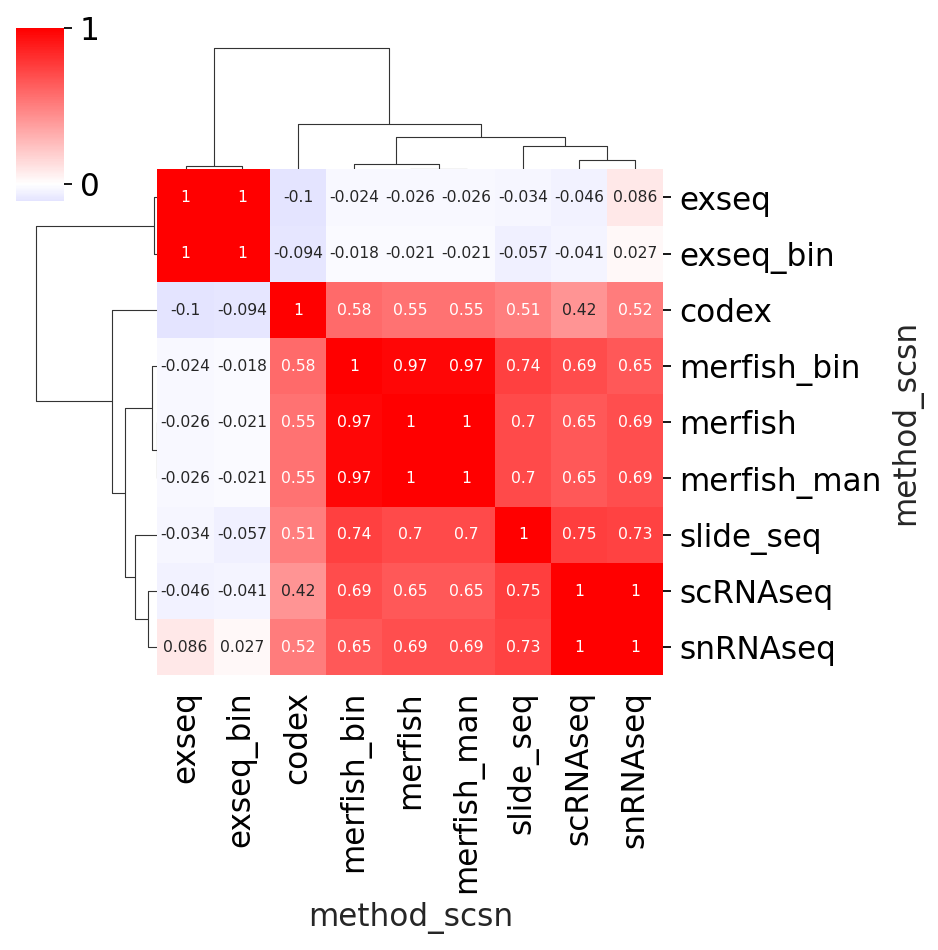

In [20]:
pl=sns.clustermap(cors,cmap="bwr",center=0,dendrogram_ratio=0.2,figsize=[6,6],annot=True,annot_kws={"size": 7})
pl.savefig(combined_dir+"pseudobulk_cor_hm.pdf")

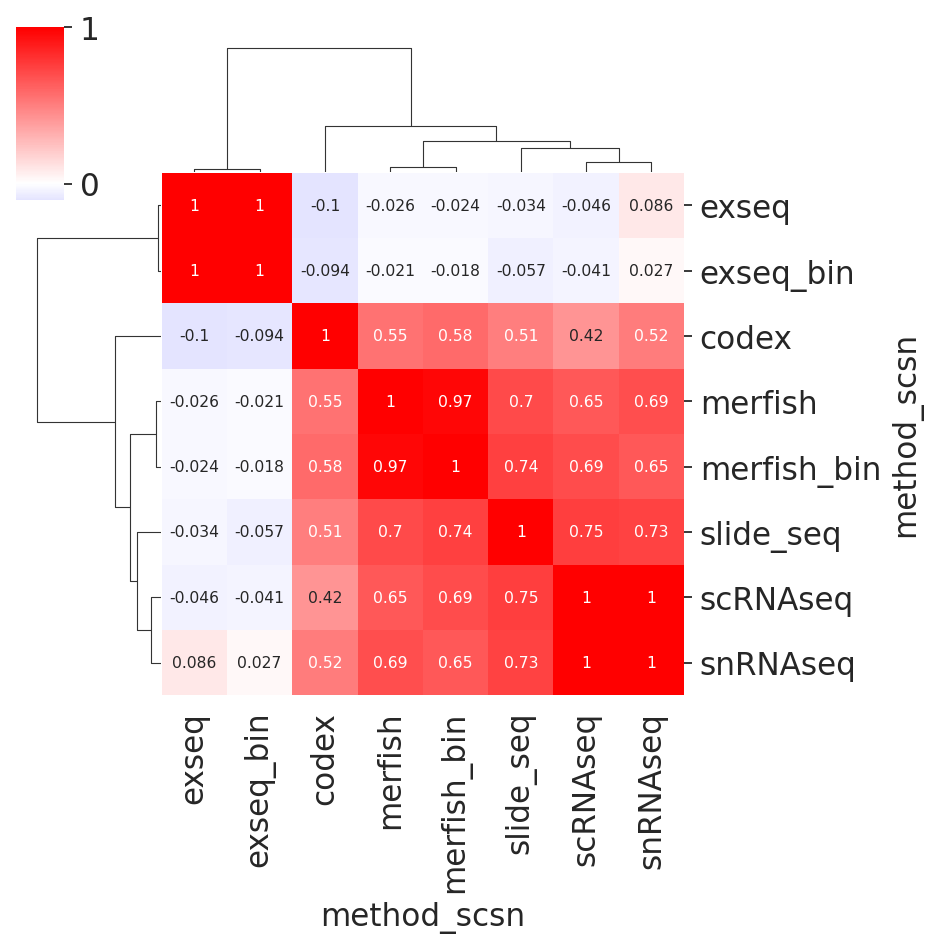

In [73]:
cors_no_man=cors.drop("merfish_man",axis=0)
cors_no_man=cors_no_man.drop("merfish_man",axis=1)
pl=sns.clustermap(cors_no_man,cmap="bwr",center=0,dendrogram_ratio=0.2,figsize=[6,6],annot=True,annot_kws={"size": 7})
pl.savefig(combined_dir+"pseudobulk_cor_no_man_hm.pdf")

In [44]:
pseudo_bulk_wide=pseudo_bulk_wide[['codex', 'exseq', 'exseq_bin', 'merfish', 'merfish_bin','merfish_man', 'slide_seq', 'scRNAseq', 'snRNAseq']]

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/seaborn/axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/seaborn/axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.


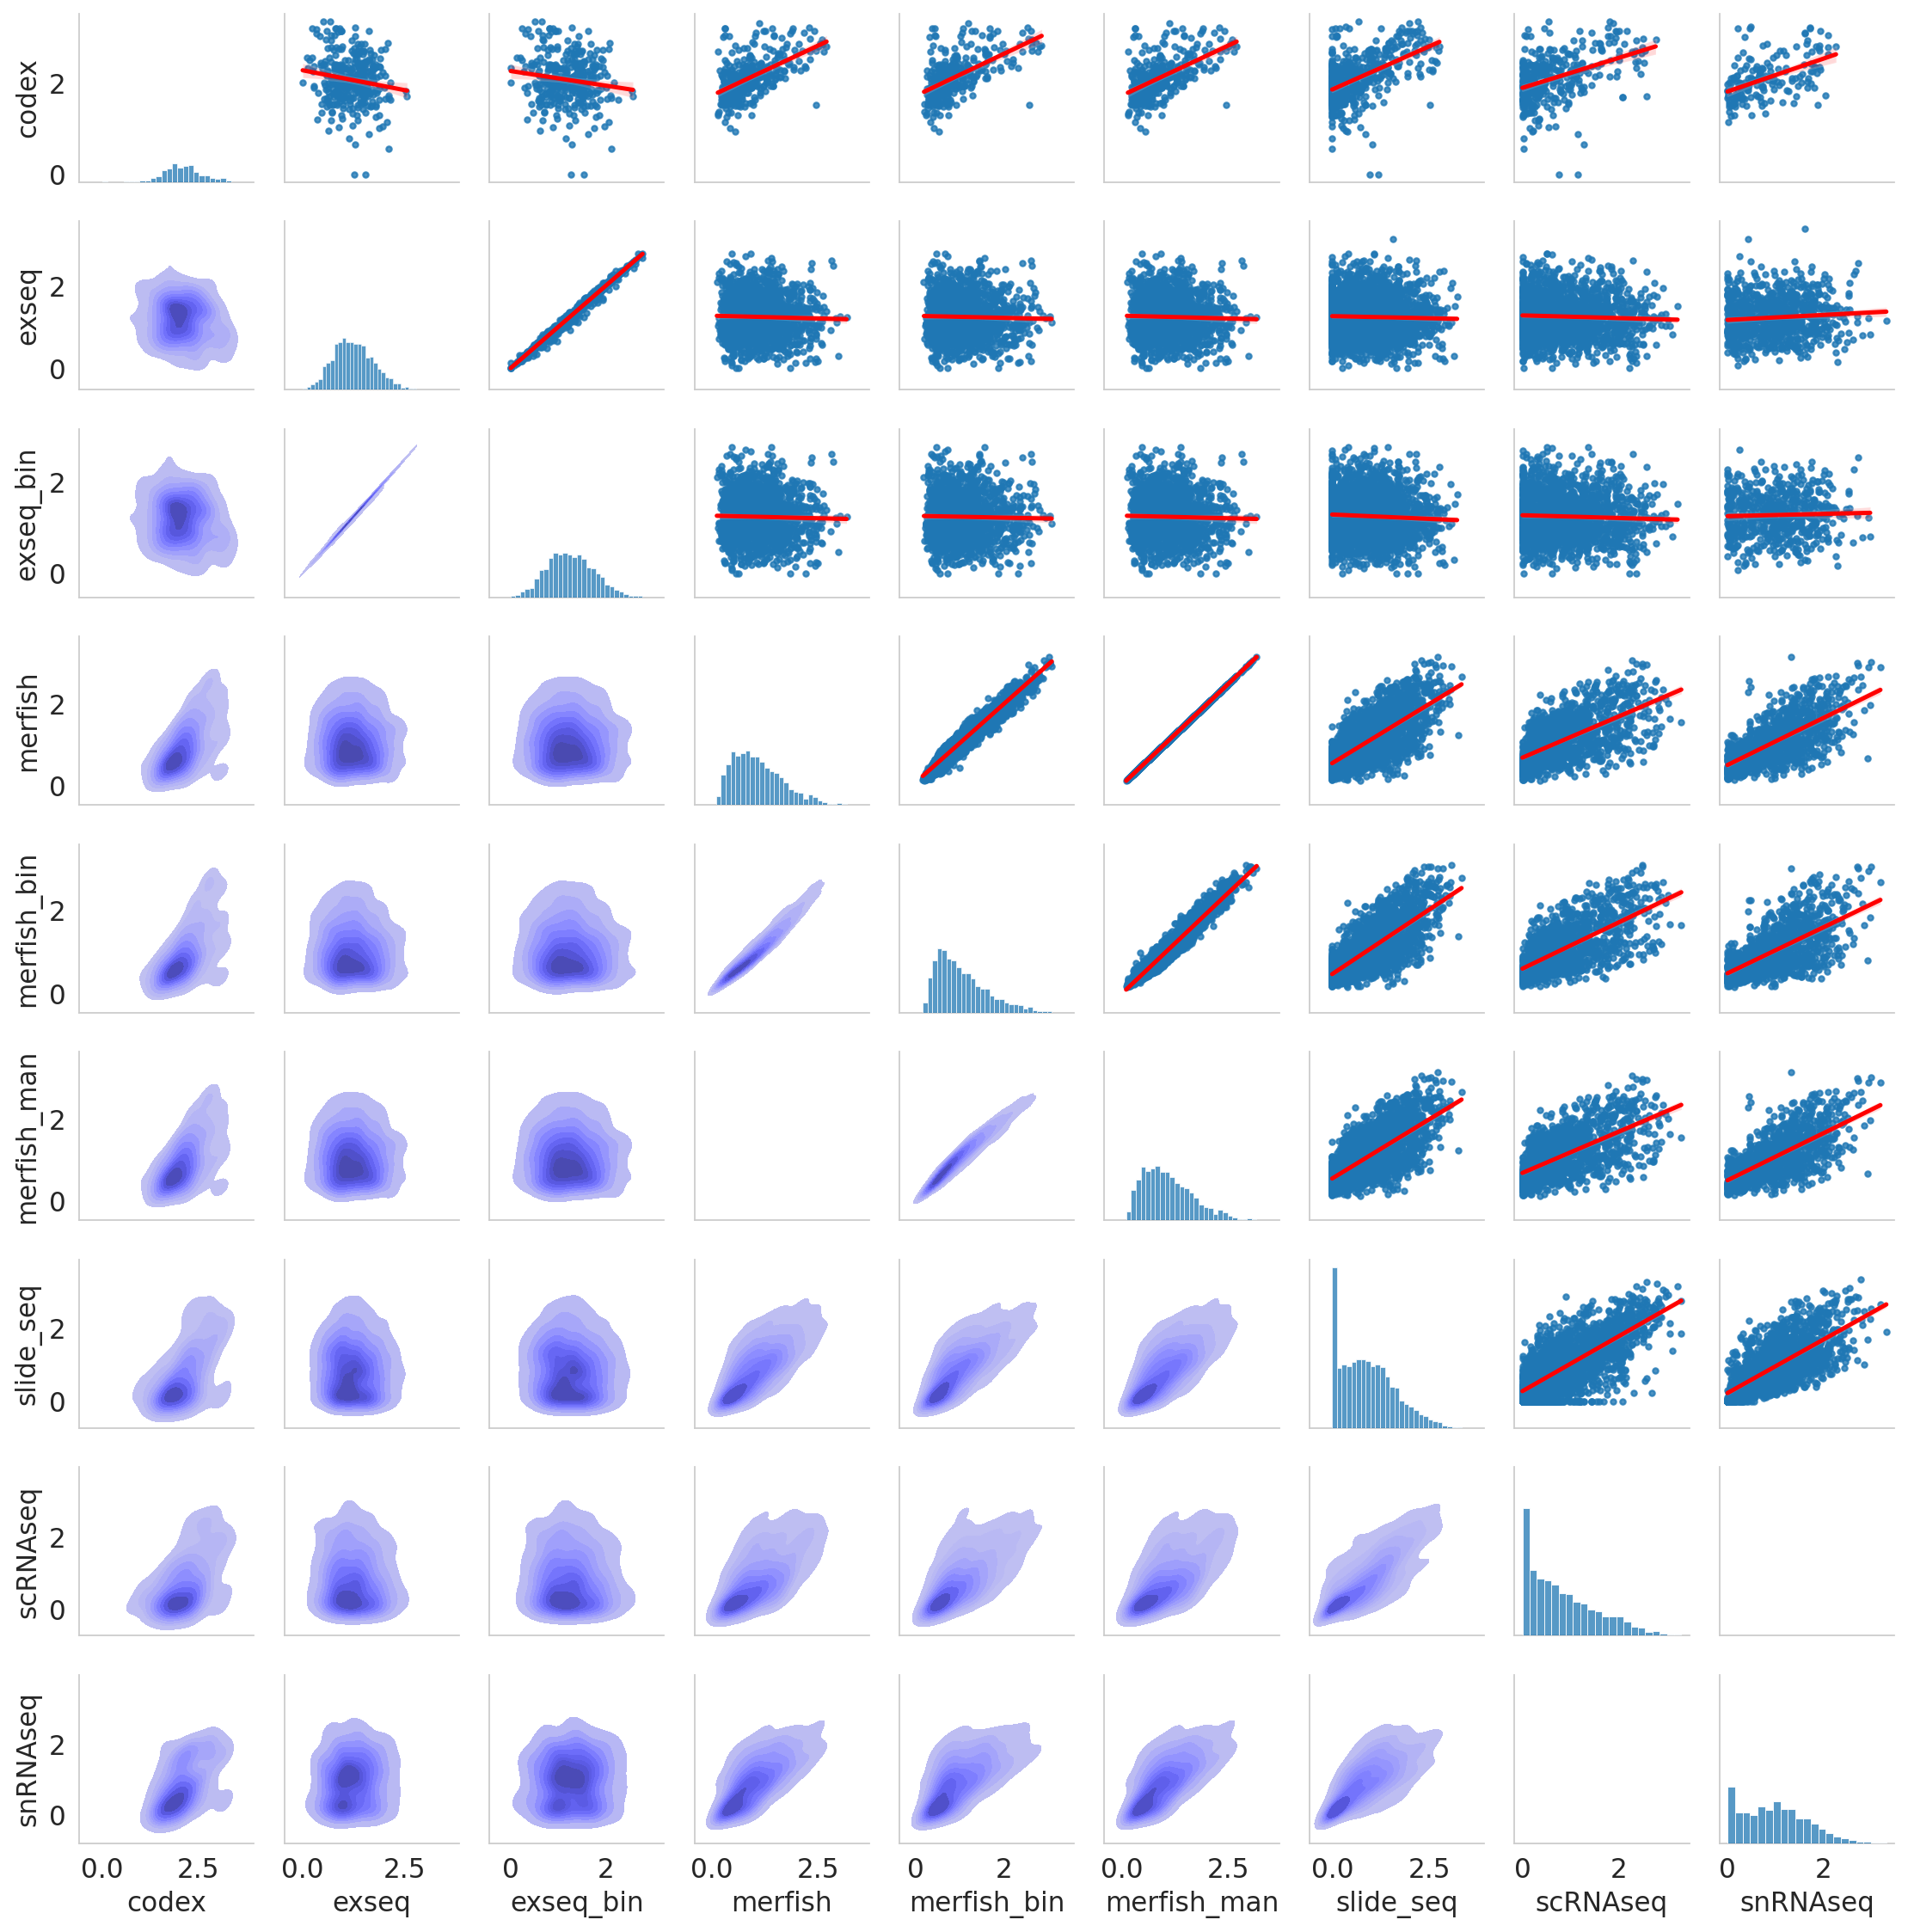

In [71]:
    g = sns.PairGrid(np.log10(pseudo_bulk_wide*10000+1), height=1.6, dropna=False)
    g.map_diag(sns.histplot)
    g.map_upper(sns.regplot, scatter_kws={"s": 8,"rasterized":True}, line_kws={"color":  "r"})
    g.map_lower(sns.kdeplot, color='blue',shade=True)
    g.savefig(combined_dir+"pseudobulk_scatter_pairPlot.pdf",dpi=150)

In [58]:
sub=pseudo_bulk_wide[pseudo_bulk_wide.index.get_level_values('sample')=="HTAPP-880-SMP-7179"]
del(sub["scRNAseq"])

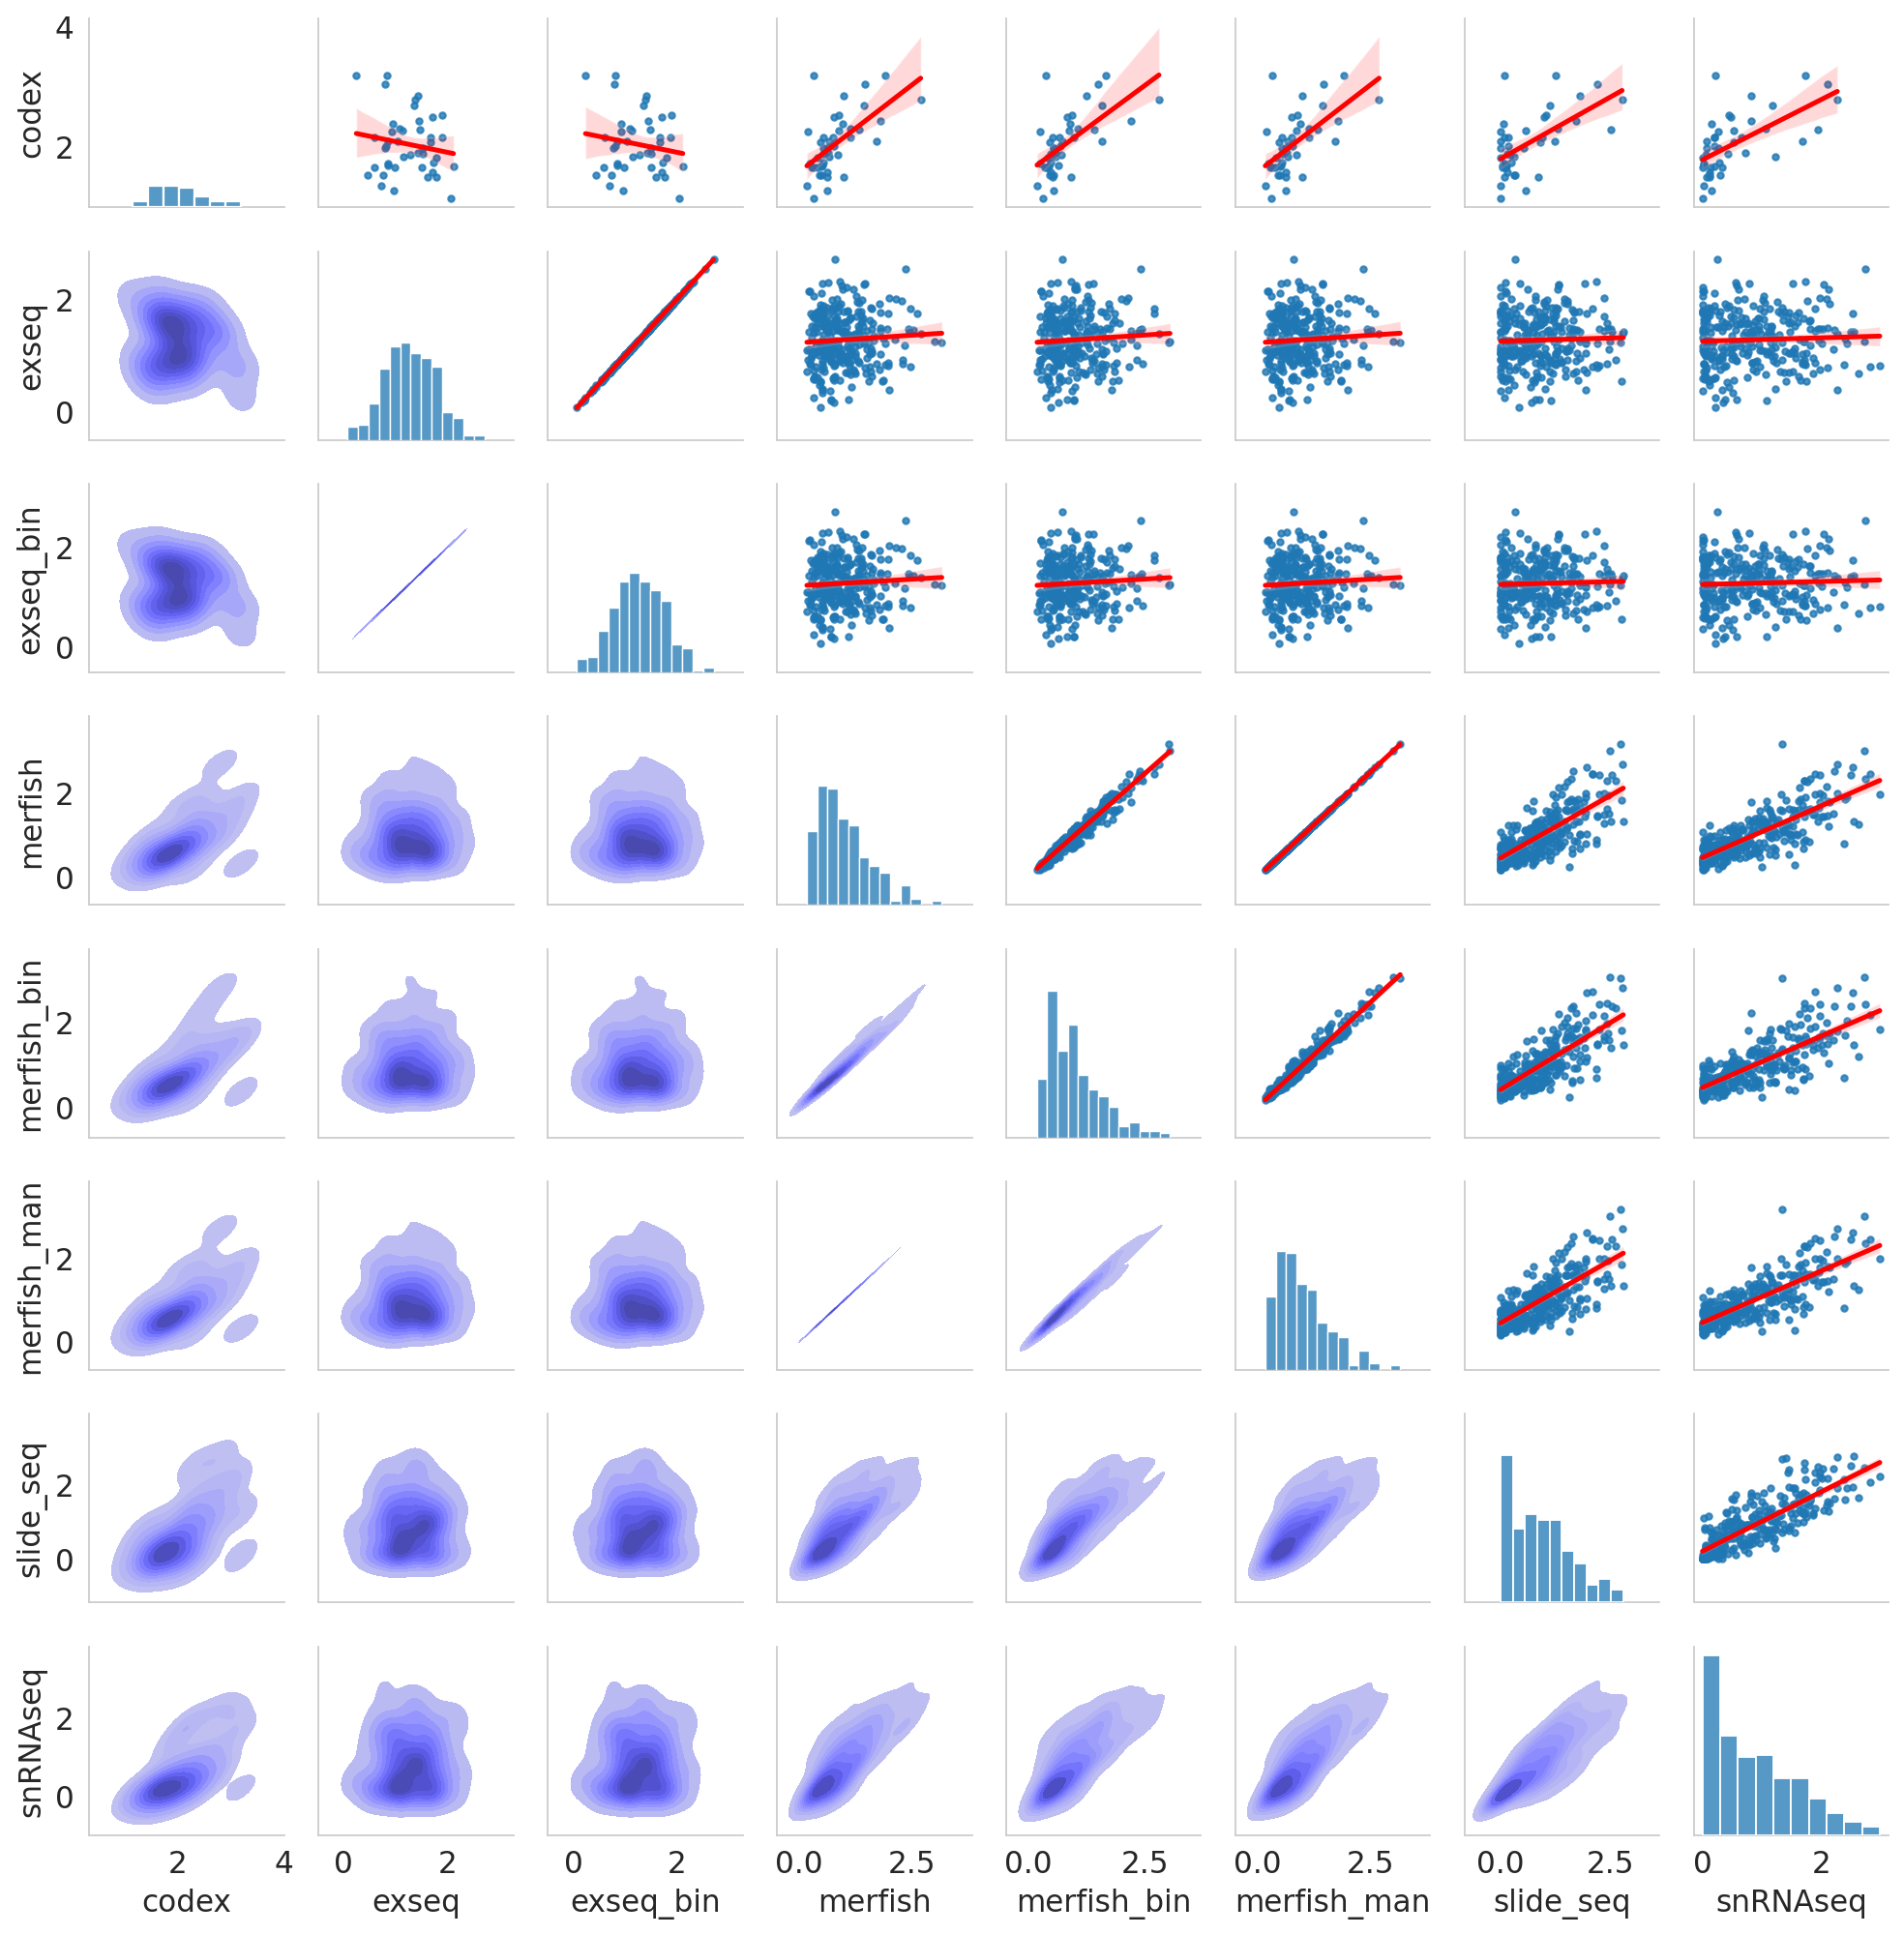

In [59]:
    g = sns.PairGrid(np.log10(sub*10000+1), height=1.6, dropna=False)
    g.map_diag(sns.histplot)
    g.map_upper(sns.regplot, scatter_kws={"s": 8}, line_kws={"color":  "r"})
    g.map_lower(sns.kdeplot, color='blue',shade=True)